## DE discovery from data (ongoing project)

## Data generation

In [2]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm

def RK4n(odefun,ics,h,span,degree):
    
    N= int( (span[1]-span[0])/h )
    
    tY = np.zeros((N+1,degree+1),dtype='float64')
    tY[0,1:] = ics
    
    
    for  i in range(N):
        tY[i+1,0] = tY[i,0] + h
        k1= odefun(tY[i,0]       , tY[i,1:])
        k2= odefun(tY[i,0] +(h/2), tY[i,1:] +(h*k1)/2 )
        k3 = odefun(tY[i,0] +(h/2), tY[i,1:] +(h*k2)/2)
        k4 = odefun(tY[i,0] +(h)  , tY[i,1:] +(h*k3))
        tY[i+1,1:] = tY[i,1:] + h*(1/6) * (k1+2*k2+2*k3+k4)
        
    return tY[:,0],tY[:,1:]




#training
print('Generate training data')

samples = 1000

np.random.seed(0)
train_xx = np.zeros((samples,1,50,50,1),dtype='float')
train_yy = np.zeros((samples,1,1,3))
d2_train = np.random.randint(low=-5,high=1,size=(samples,1,3)) - np.round(np.random.rand(samples,1,3),1)
ic_train = np.random.randint(low=0,high=5,size=(samples,2))
from functools import partial 

def partial_ode_fun(d4,x,y):
        #candidate library
        A = np.zeros((2,3))
        A[0,1]=1;A[1] = d4
        V = np.array([y[0],y[1],x]) 
        AV =np.matmul(A,V)
        return AV

for i in tqdm(range(samples)):
    ode_fun = partial(partial_ode_fun,d2_train[i])
    sol  = RK4n(ode_fun,ics=ic_train[i],h=1e-3,span=np.array([0,2.5]),degree =2)
    train_xx[i] = ((sol[1][:-1,0])).reshape(1,50,50,1)
    train_yy[i,0] = d2_train[i,-1]
    


#scaling

x_min,x_max = np.min(train_xx),np.max(train_xx)
train_x = (train_xx-x_min)/((x_max-x_min)+1e-3)

y_min,y_max = np.min(train_yy),np.max(train_yy)
train_y = (train_yy-y_min)/((y_max-y_min)+1e-3)


#validation

samples = 100
np.random.seed(10)
val_xx = np.zeros((samples,1,50,50,1),dtype='float')
val_yy = np.zeros((samples,1,1,3))
d2_val = np.random.randint(low=-5,high=1,size=(samples,1,3)) - np.round(np.random.rand(samples,1,3),1)
ic_val = np.random.randint(low=0,high=5,size=(samples,2))

print('Generate validation data')

for i in tqdm(range(samples)):
    ode_fun = partial(partial_ode_fun,d2_val[i])
    sol  = RK4n(ode_fun,ics=ic_val[i],h=1e-3,span=np.array([0,2.5]),degree =2)
    val_xx[i] = ((sol[1][:-1,0])).reshape(1,50,50,1)
    val_yy[i,0] = d2_val[i,-1]
    


#scaling

# x_min,x_max = np.min(train_xx),np.max(train_xx)
val_x = (val_xx-x_min)/((x_max-x_min)+1e-3)

# y_min,y_max = np.min(train_yy),np.max(train_yy)
val_y = (val_yy-y_min)/((y_max-y_min)+1e-3)



Generate training data



Generate validation data


# Model

In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow

def conv(x,f,k):
    x = TimeDistributed(Conv2D(f,(k,k),strides=1,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return x
    

def dense_block(tensor, f, r,k):
    for _ in range(r):
        x = conv(tensor, f=4*f, k=1)
        x = conv(x, f=f, k=k)
        tensor = Concatenate()([tensor, x])
    return tensor


def transition(x,s):
    ff = int(tensorflow.keras.backend.int_shape(x)[-1] * 0.5)
    m0 = TimeDistributed(Conv2D(ff,(1,1),strides=2*s,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return m0

def dfn():
    
    k=3
    s=1;
    LR=1e-4
    
    r1,r2,r3 = 2 , 4 ,8
    f0,f1,f2,f3 = 128,32,32,32
    l1,l2 = 128 ,64

    x = Input(shape=(1,50,50, 1))
    c0 = TimeDistributed(Conv2D(f0,(k,k),strides=1,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
########################################################################################################    
    e1 = dense_block(c0,f1,r=r1,k=k);m1 = transition(e1,s)
    e2 = dense_block(m1,f2,r=r2,k=k);m2 = transition(e2,s)
    e3 = dense_block(m2,f3,r=r3,k=k);
########################################################################################################
    e = ConvLSTM2D(l1,(2,2),padding='same',return_sequences=True)(e3)
    b = ConvLSTM2D(l2,(2,2),padding='same',return_sequences=True)(e)
########################################################################################################
    b = TimeDistributed(Flatten())(b)
    d3 =TimeDistributed(Dense(3,activation='linear'))(b)
    d3 =TimeDistributed(Reshape((1,3)))(d3)
    model = Model(x,d3)
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae',optimizer=optimizer,metrics=['mse'])
    return model

model = dfn()
# model.summary()


In [54]:
# csv_logger = tensorflow.keras.callbacks.CSVLogger('train step=10 12x12.log')
# early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='loss',min_delta=5e-5, patience=5, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
reduce_lr_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = 'loss',factor = 0.5,patience = 5,verbose = 1,cooldown=1,min_delta = 1e-4,min_lr=1e-8 )
# model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint('step=100 12x12.h5', monitor='loss', verbose=1, save_best_only=False,save_weights_only=False, mode='auto', save_freq='epoch',)
model.fit(train_x,train_y,
          validation_data=(val_x,val_y),
          epochs=100,
          callbacks=[reduce_lr_callback],
         )

Epoch 1/100
32/32 [==============================] - 5s 159ms/step - loss: 0.0401 - mse: 0.0039 - val_loss: 0.0434 - val_mse: 0.0045
Epoch 2/100
32/32 [==============================] - 5s 157ms/step - loss: 0.0403 - mse: 0.0039 - val_loss: 0.0434 - val_mse: 0.0041
Epoch 3/100
32/32 [==============================] - 5s 155ms/step - loss: 0.0401 - mse: 0.0039 - val_loss: 0.0472 - val_mse: 0.0050
Epoch 4/100
32/32 [==============================] - 5s 154ms/step - loss: 0.0417 - mse: 0.0040 - val_loss: 0.0454 - val_mse: 0.0047
Epoch 5/100
32/32 [==============================] - 5s 157ms/step - loss: 0.0401 - mse: 0.0038 - val_loss: 0.0498 - val_mse: 0.0055
Epoch 6/100
32/32 [==============================] - ETA: 0s - loss: 0.0414 - mse: 0.0040
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
32/32 [==============================] - 5s 155ms/step - loss: 0.0414 - mse: 0.0040 - val_loss: 0.0436 - val_mse: 0.0043
Epoch 7/100
32/32 [=========================

## View prediction

In [14]:
from functools import partial 

def partial_ode_fun(d4,x,y):
        #candidate library
        A = np.zeros((2,3))
        A[0,1]=1;A[1,:] = d4
        V = np.array([y[0],y[1],x]) 
        AV =np.matmul(A,V)
        return AV

def solve_from_prediction(coeffs,ics):
    ode_fun = partial(partial_ode_fun,coeffs)
    sol  = RK4n(ode_fun,ics=ics,h=1e-3,span=np.array([0,2.5]),degree =2)
    return ((sol[1][:-1,0]))

# j = 120

# coeffs = ( model.predict(train_x[[j]]) * ((y_max-y_min)+1e-3) ) + y_min
# prediction = solve_from_prediction(coeffs[0,0,0])

# plt.plot(prediction,'-r')
# plt.plot(xx[j].reshape(-1,1))


## Generate test samples

In [27]:
import matplotlib.pyplot as plt
# import torch
import tensorflow
import numpy as np
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

mpl.rcParams['figure.dpi'] = 72
mpl.rcParams.update({'font.size': 35})
mpl.rcParams['axes.linewidth'] = 2
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

In [29]:
samples = 50
np.random.seed(50)
test_xx = np.zeros((samples,1,50,50,1),dtype='float')
test_yy = np.zeros((samples,1,1,3))
d2_test = np.random.randint(low=-5,high=1,size=(samples,1,3)) - np.round(np.random.rand(samples,1,3),1)
ic_test = np.random.randint(low=0,high=5,size=(samples,2))

print('Generate test data')

for i in tqdm(range(samples)):
    ode_fun = partial(partial_ode_fun,d2_test[i])
    sol  = RK4n(ode_fun,ics=ic_test[i],h=1e-3,span=np.array([0,2.5]),degree =2)
    test_xx[i] = ((sol[1][:-1,0])).reshape(1,50,50,1)
    test_yy[i,0] = d2_test[i,-1]
    


#scaling

x_min,x_max = np.min(train_xx),np.max(train_xx)
test_x = (test_xx-x_min)/((x_max-x_min)+1e-3)

y_min,y_max = np.min(train_yy),np.max(train_yy)
test_y = (test_yy-y_min)/((y_max-y_min)+1e-3)

Generate test data


## View test prediction

In [35]:
import sklearn
import sklearn.metrics

In [57]:
test_x.shape

(50, 1, 50, 50, 1)

In [84]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['axes.linewidth'] = 2
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

In [164]:
from ipywidgets import IntSlider,interact
from IPython.display import Math

slider = IntSlider(low=0,max=samples-1,value=0)
noise = 0.00

np.random.seed(100)

@interact(j=slider)
def show(j):
    
    a,b,c = -d2_test[j][0]
    
    coeffs = ( model.predict(test_x[[j]]+np.random.rand(50,50,1)*noise) * ((y_max-y_min)+1e-3) ) + y_min
    prediction = solve_from_prediction(coeffs[0,0,0],ic_test[j])
    
    k,l,m = -coeffs[0,0,0]
#     l = np.round(l,2)
    plt.figure(figsize=(15,5))
    plt.subplot(2,1,1)
    plt.plot(np.arange(0,2.5,1e-3),prediction,'--k')
    plt.plot(np.arange(0,2.5,1e-3),test_xx[j].reshape(-1,1),'-r')
    plt.xlabel('$x$');plt.ylabel('$y$')
    MSE = sklearn.metrics.mean_squared_error(test_xx[j].reshape(-1,1),prediction)
    plt.legend([f'$Prediction$','$RK4 \ result$'])
    plt.title('$Test \ samples \ prediction$')
    
    plt.subplot(2,1,2)
    plt.yticks(np.arange(-6,12,1))
    plt.text(0.1,8,'$correct \  \ \   \ \ DE : {dy^2\over dx^2} + $' + f'${b}$'  + '${dy\over dx} + $' +f'${a} $'  + '${y} + $' +f'${c}$' '${x} + $' )
    plt.text(0.1,4,'$predicted \  DE : {dy^2\over dx^2} + $' + f'${l}$'  + '${dy\over dx} + $' +f'${k} $'  + '${y} + $' +f'${m}$' '${x}$' )
    plt.text(0.1,0,f'$Nosie= \ $' +  f'${noise*100}$' + f'$\%$' )
    plt.text(0.1,-4,f'$MSE= \ $' +  f'${np.round(MSE*10**3,3)}e-3$'  )
    plt.yticks([]);plt.xticks([])
    

    
    

interactive(children=(IntSlider(value=0, description='j', max=49), Output()), _dom_classes=('widget-interact',…

## Test with sympy

In [47]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x =sp.symbols('x')
y = sp.Function('y')
#expression of DE

j = 10

a,b,c = -d2_train[j][0]

expr = sp.Derivative(y(x),x,x) + b*sp.Derivative(y(x),x) + a* y(x)+c*x 
expr
# solution of DE
sol_exact= sp.dsolve(expr, y(x),
 ics={y(0):ic_train[j][0],
 y(x).diff(x).subs(x, 0): ic_train[j][1],
 })
sol_exact_func=sp.lambdify(x,sol_exact.rhs)
expr

4.4*x + 2.4*y(x) + 5.6*Derivative(y(x), x) + Derivative(y(x), (x, 2))

In [46]:
train_yy[j]

array([[[-2.4, -5.6, -4.4]]])

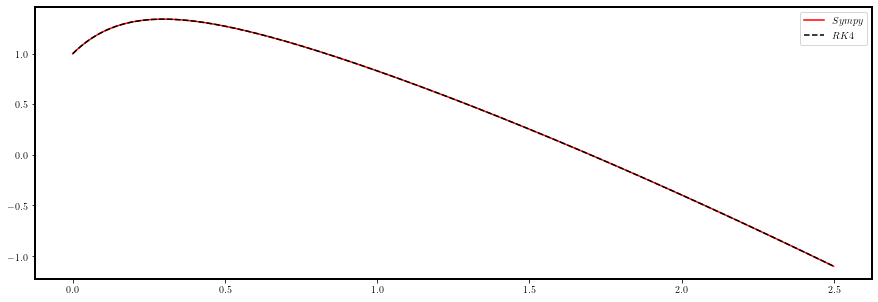

In [53]:
sympy_res = [ sol_exact_func(i) for i in np.arange(0,2.5,1e-3)]
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,2.5,1e-3),sympy_res,'-r')
plt.plot(np.arange(0,2.5,1e-3),train_xx[j].reshape(-1,1),'--k')
plt.legend(['$Sympy$','$RK4$'])